In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy import ndimage
from skimage import filters
import pims
import trackpy as tp
import os
from skimage.transform import probabilistic_hough_line

ImportError: No module named pims

In [6]:
frames=pims.open('../Images/*.tif')

NameError: name 'pims' is not defined

In [3]:
plt.imshow(frames[0])

NameError: name 'frames' is not defined

In [4]:
# def pipeline2(func): #pseudo code just to understand how a decorator works
#     def wrapper(img):
#         open video
#         [] = out
#         for loopp frames:
#             out += func(img),
#         return out
#     return wrapper

In [6]:
@pims.pipeline #with the pipeline decorator data is only accessed one element at a time
def preprocess(img):
    """Apply image processing functions to return a binary image"""
    #median filtering
    img=ndimage.filters.median_filter(img,size=2)
    #normalized intensity
    norm=(img-img.min())/float(img.max()-img.min())
    #binarization with threshold
    thresh=0.46
    norm[norm>thresh]=1.0
    norm[norm<thresh]=0.0
    return norm

In [7]:
imm=preprocess(frames)

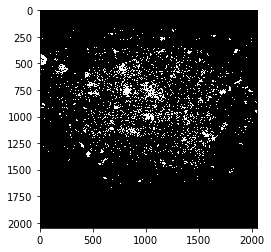

In [8]:
plt.imshow(imm[0])

In [9]:
lines=probabilistic_hough_line(imm[0],threshold=30,line_length=55,line_gap=1) #probabilistic line detection

90


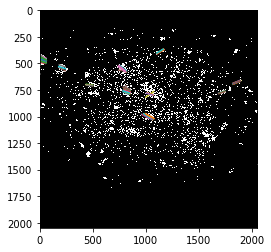

In [10]:
print (len(lines))
P0=[]
P1=[]
for line in lines:
    p0,p1=line
    P0.append(p0)
    P1.append(p1)
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.imshow(imm[0])

(900, 1300)

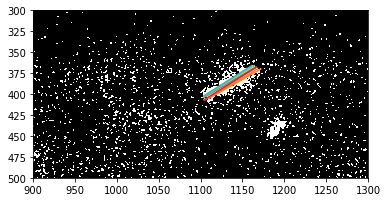

In [11]:
#zoom in interesting zone
for line in lines:
    p0,p1=line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.imshow(imm[0])
plt.ylim(500,300)
plt.xlim(900,1300)

In [12]:
CENTROID_X=[]
CENTROID_Y=[]
nolist=[]
for idx1 in np.arange(0,len(P0)-1):
    if idx1 not in nolist:
        CENTROID_X.append((P0[idx1][0]+P1[idx1][0])/2.0)
        CENTROID_Y.append((P0[idx1][1]+P1[idx1][1])/2.0)
        for idx2 in np.arange(idx1+1,len(P0)):
            if ((P0[idx1][0]-P0[idx2][0])*(P0[idx1][0]-P0[idx2][0]))<20*20:
                nolist.append(idx2) 

[27.5, 784.5, 823.0, 1713.0, 1037.5, 1859.5, 470.5, 213.0, 1141.0, 1036.0, 996.5] [473.0, 559.5, 751.5, 769.5, 1005.5, 673.5, 698.5, 553.0, 387.5, 791.5, 998.0]


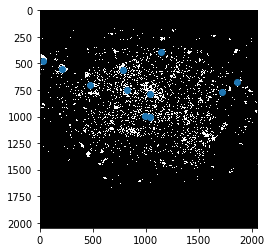

In [13]:
plt.scatter(CENTROID_X,CENTROID_Y)
plt.imshow(imm[0])
print (CENTROID_X,CENTROID_Y)

[1071.5, 38.0] [382.0, 813.5]


Text(0.5,1,u'centroid line last image')

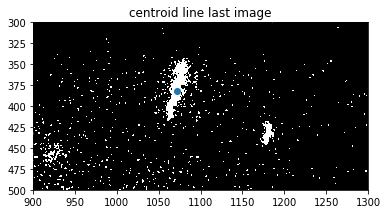

In [22]:
plt.scatter(CENTROID_X,CENTROID_Y)
plt.imshow(imm[-1])
print (CENTROID_X,CENTROID_Y)
plt.ylim(500,300)
plt.xlim(900,1300)
plt.title('centroid line last image')

In [15]:
#try to apply the same analysis to all figures in the stack
features=pd.DataFrame()
for num,img in enumerate(imm):
    lines=probabilistic_hough_line(img,threshold=20,line_length=55,line_gap=1) #probabilistic line detection
    P0=[]
    P1=[]
    for line in lines:
        p0,p1=line
        P0.append(p0)
        P1.append(p1)
    CENTROID_X=[]
    CENTROID_Y=[]
    nolist=[]
    for idx1 in np.arange(0,len(P0)-1):
        if idx1 not in nolist:
            CENTROID_X.append((P0[idx1][0]+P1[idx1][0])/2.0)
            CENTROID_Y.append((P0[idx1][1]+P1[idx1][1])/2.0)
            for idx2 in np.arange(idx1+1,len(P0)):
                if ((P0[idx1][0]-P0[idx2][0])*(P0[idx1][0]-P0[idx2][0]))<20*20:
                    nolist.append(idx2)   
    # Store features which survived to the criterions
    for nn,cx in enumerate(CENTROID_X):
        features = features.append([{'y': CENTROID_Y[nn],
                                     'x': cx,
                                     'frame': num,
                                     },])

In [16]:
features

,frame,x,y
0,0,29.5,486.5
0,0,1026.5,1007.0
0,0,821.0,763.0
0,0,812.5,756.0
0,0,1024.5,1008.0
0,0,1854.0,677.0
0,0,1716.5,775.5
0,0,996.5,998.0
0,0,1136.0,384.5
0,0,470.0,705.0


Frame 9: 2 trajectories present.


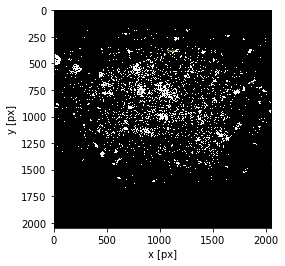

In [17]:
t = tp.link_df(features, search_range=30, memory=5)
tp.plot_traj(t, superimpose=imm[0])

In [18]:
t.head()

,frame,x,y,particle
0,0,29.5,486.5,0
0,0,1026.5,1007.0,1
0,0,821.0,763.0,2
0,0,812.5,756.0,3
0,0,1024.5,1008.0,4


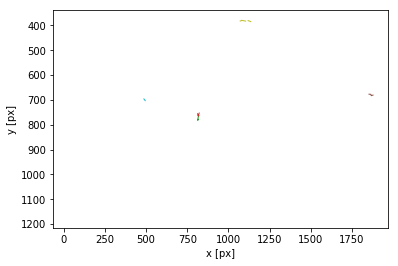

In [23]:
tp.plot_traj(t)

In [20]:
unstacked = t.set_index(['frame', 'particle']).unstack()

In [21]:
unstacked

x                                                               \
particle    0       1      2      3       4       5       6      7       8    
frame                                                                         
0         29.5  1026.5  821.0  812.5  1024.5  1854.0  1716.5  996.5  1136.0   
2          NaN     NaN  815.0  817.0     NaN  1865.5     NaN    NaN  1119.5   
3          NaN     NaN  813.5  815.5     NaN  1867.5     NaN    NaN     NaN   
4          NaN     NaN  817.5  822.5     NaN  1878.5     NaN    NaN  1104.5   
6          NaN     NaN    NaN    NaN     NaN     NaN     NaN    NaN  1084.5   
7          NaN     NaN    NaN    NaN     NaN     NaN     NaN    NaN  1081.0   
8          NaN     NaN    NaN    NaN     NaN     NaN     NaN    NaN  1076.0   
9          NaN     NaN    NaN    NaN     NaN     NaN     NaN    NaN  1071.5   

                 ...      y                                                   \
particle     9   ...     7      8      9      10     11     12     13     14   
frame            ...                                                           
0         470.0  ...  998.0  384.5  705.0  697.0  786.0  551.0    NaN    NaN   
2           NaN  ...    NaN  380.5    NaN    NaN    NaN    NaN  772.5    NaN   
3         486.5  ...    NaN    NaN  696.0    NaN  786.5    NaN    NaN  748.0   
4         494.5  ...    NaN  382.5  703.0    NaN    NaN    NaN  760.5    NaN   
6           NaN  ...    NaN  380.0    NaN    NaN    NaN    NaN    NaN    NaN   
7           NaN  ...    NaN  379.0    NaN    NaN    NaN    NaN    NaN    NaN   
8           NaN  ...    NaN  381.5    NaN    NaN    NaN    NaN    NaN    NaN   
9           NaN  ...    NaN  382.0    NaN    NaN    NaN    NaN    NaN    NaN   

                         
particle      15     16  
frame                    
0            NaN    NaN  
2            NaN    NaN  
3         1175.5    NaN  
4            NaN    NaN  
6            NaN    NaN  
7            NaN    NaN  
8            NaN    NaN  
9            NaN  813.5  

[8 rows x 34 columns]